In [ ]:
!nvidia-smi

Sat Apr 17 20:43:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    34W /  70W |   4936MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download("stopwords")
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')

import re
from collections import Counter

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import confusion_matrix


import plotly.express as px
from plotly.offline import plot

import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

print('Tensorflow version: ', tf.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Tensorflow version:  2.4.1


In [ ]:
true = pd.read_csv(yourpath)
fake = pd.read_csv(yourpath)

print('INFO - True')
true.info()

print('\n-------------\nINFO - False')
fake.info()

INFO - True
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB

-------------
INFO - False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [ ]:
true.isna().sum() # make sure no missing elements

title      0
text       0
subject    0
date       0
dtype: int64

In [ ]:
fake.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [ ]:
true['is_fake'] = 0
fake['is_fake'] = 1

# Merge two dataframes into one
df = pd.concat([true,fake]).reset_index(drop = True)

# As it does not have an impact on classification drop the date
df.drop(['date'], axis = 1, inplace = True)

In [ ]:
df.sample(4)

title  ...                                       clean_joined
3434   Russia says still likely to back Paris climate...  ...  russia says likely paris climate deal despite ...
28613   Republican Governor Refuses Medicaid Expansio...  ...  republican governor refuses medicaid expansion...
14576  Trump discussed free trade pact with Japan's A...  ...  trump discussed free trade pact japan envoy sa...
7523          Clinton's pantsuits inspire flashmob video  ...  clinton pantsuits inspire flashmob video reute...

[4 rows x 7 columns]

In [ ]:
df['orig'] = df['title'] + ' ' + df['text'] #combine title and text
df['orig'][13] # sample

'Trump on Twitter (Dec 27) - Trump, Iraq, Syria The following statements\xa0were posted to the verified Twitter accounts of U.S. President Donald Trump, @realDonaldTrump and @POTUS.  The opinions expressed are his own.\xa0Reuters has not edited the statements or confirmed their accuracy.  @realDonaldTrump : - “On 1/20 - the day Trump was inaugurated - an estimated 35,000 ISIS fighters held approx 17,500 square miles of territory in both Iraq and Syria. As of 12/21, the U.S. military estimates the remaining 1,000 or so fighters occupy roughly 1,900 square miles...” via @jamiejmcintyre  [1749 EST] - Just left West Palm Beach Fire & Rescue #2. Met with great men and women as representatives of those who do so much for all of us. Firefighters, paramedics, first responders - what amazing people they are! [1811 EST] - “On 1/20 - the day Trump was inaugurated - an estimated 35,000 ISIS fighters held approx 17,500 square miles of territory in both Iraq and Syria. As of 12/21, the U.S. military

In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 're', 'edu', 'use'])

In [ ]:
for sample in range(5):
  print('%d. sample has stop-word %s' %(sample, np.random.choice(stop_words)))

0. sample has stop-word her
1. sample has stop-word this
2. sample has stop-word both
3. sample has stop-word and
4. sample has stop-word to


In [ ]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
    return result

df['clean'] = df['orig'].apply(preprocess) # this may take few secs or mins

In [ ]:
df.clean

0        [budget, fight, looms, republicans, flip, fisc...
1        [military, accept, transgender, recruits, mond...
2        [senior, republican, senator, mueller, washing...
3        [russia, probe, helped, australian, diplomat, ...
4        [trump, wants, postal, service, charge, amazon...
                               ...                        
44893    [mcpain, john, mccain, furious, iran, treated,...
44894    [justice, yahoo, settles, mail, privacy, class...
44895    [sunnistan, allied, safe, zone, plan, territor...
44896    [blow, million, jazeera, america, finally, cal...
44897    [navy, sailors, held, iranian, military, signs...
Name: clean, Length: 44898, dtype: object

In [ ]:
results = Counter()
df['clean'].apply(results.update)
print('There are %d unique words' %(len(results)-1))

There are 108705 unique words


In [ ]:
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x)) # re-convert to sentence

# Example of cleaned sentence
df['clean_joined'][13]

'trump twitter trump iraq syria following statements posted verified twitter accounts president donald trump realdonaldtrump potus opinions expressed reuters edited statements confirmed accuracy realdonaldtrump trump inaugurated estimated isis fighters held approx square miles territory iraq syria military estimates remaining fighters occupy roughly square miles jamiejmcintyre left west palm beach rescue great women representatives firefighters paramedics responders amazing people trump inaugurated estimated isis fighters held approx square miles territory iraq syria military remaining fighters occupy roughly square miles jamiejmcintyre dcexaminer arrests members associates trump lirh source link jpexyr'

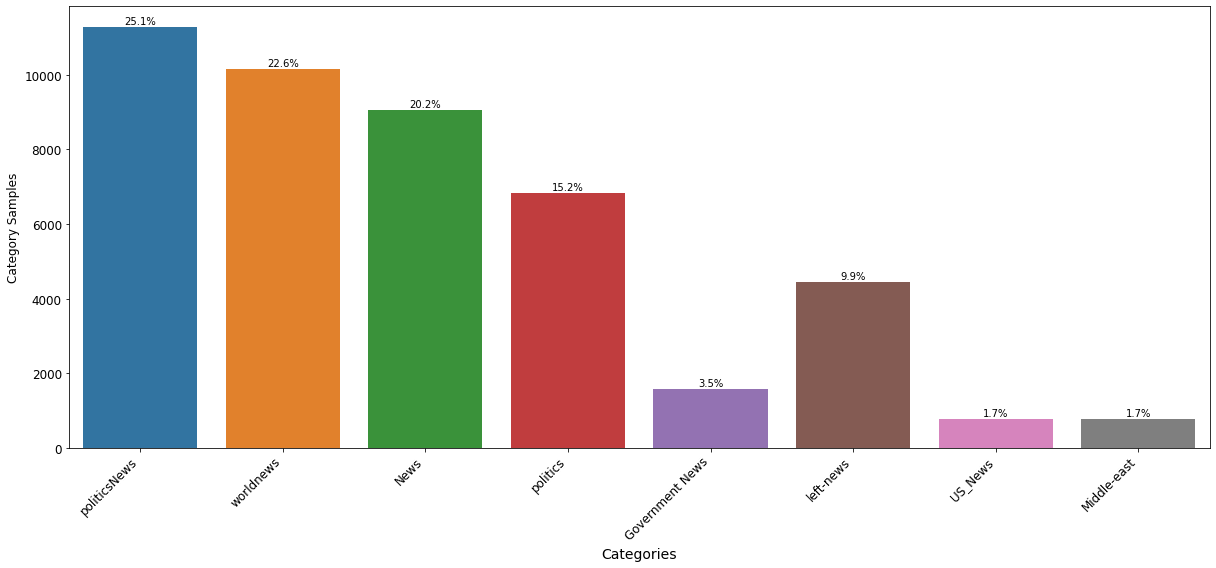

In [ ]:
plt.figure(figsize= (17,8))
ax = sns.countplot(data = df, x = 'subject')

plt.xticks(size=12)
plt.xlabel('Categories', size=14)
plt.yticks(size=12)
plt.ylabel('Category Samples', size=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

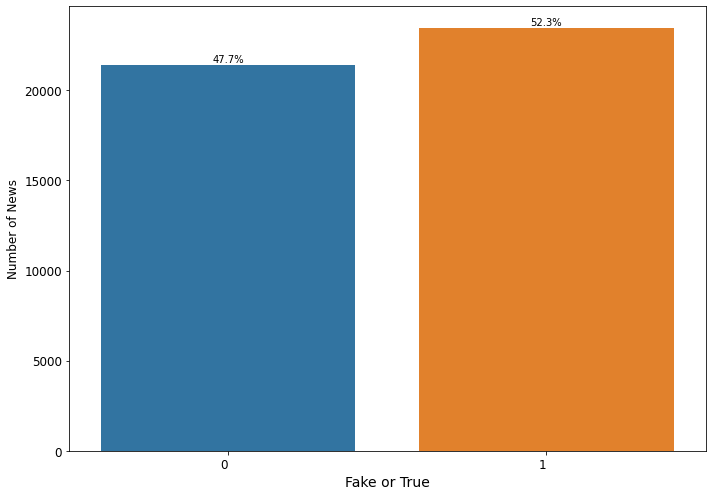

In [ ]:
plt.figure(figsize= (10,7))
ax = sns.countplot(data = df, x = 'is_fake')

plt.xticks(size=12)
plt.xlabel('Fake or True', size=14)
plt.yticks(size=12)
plt.ylabel('Number of News', size=12)
ax.set_xticklabels(ax.get_xticklabels(), ha="right")

total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

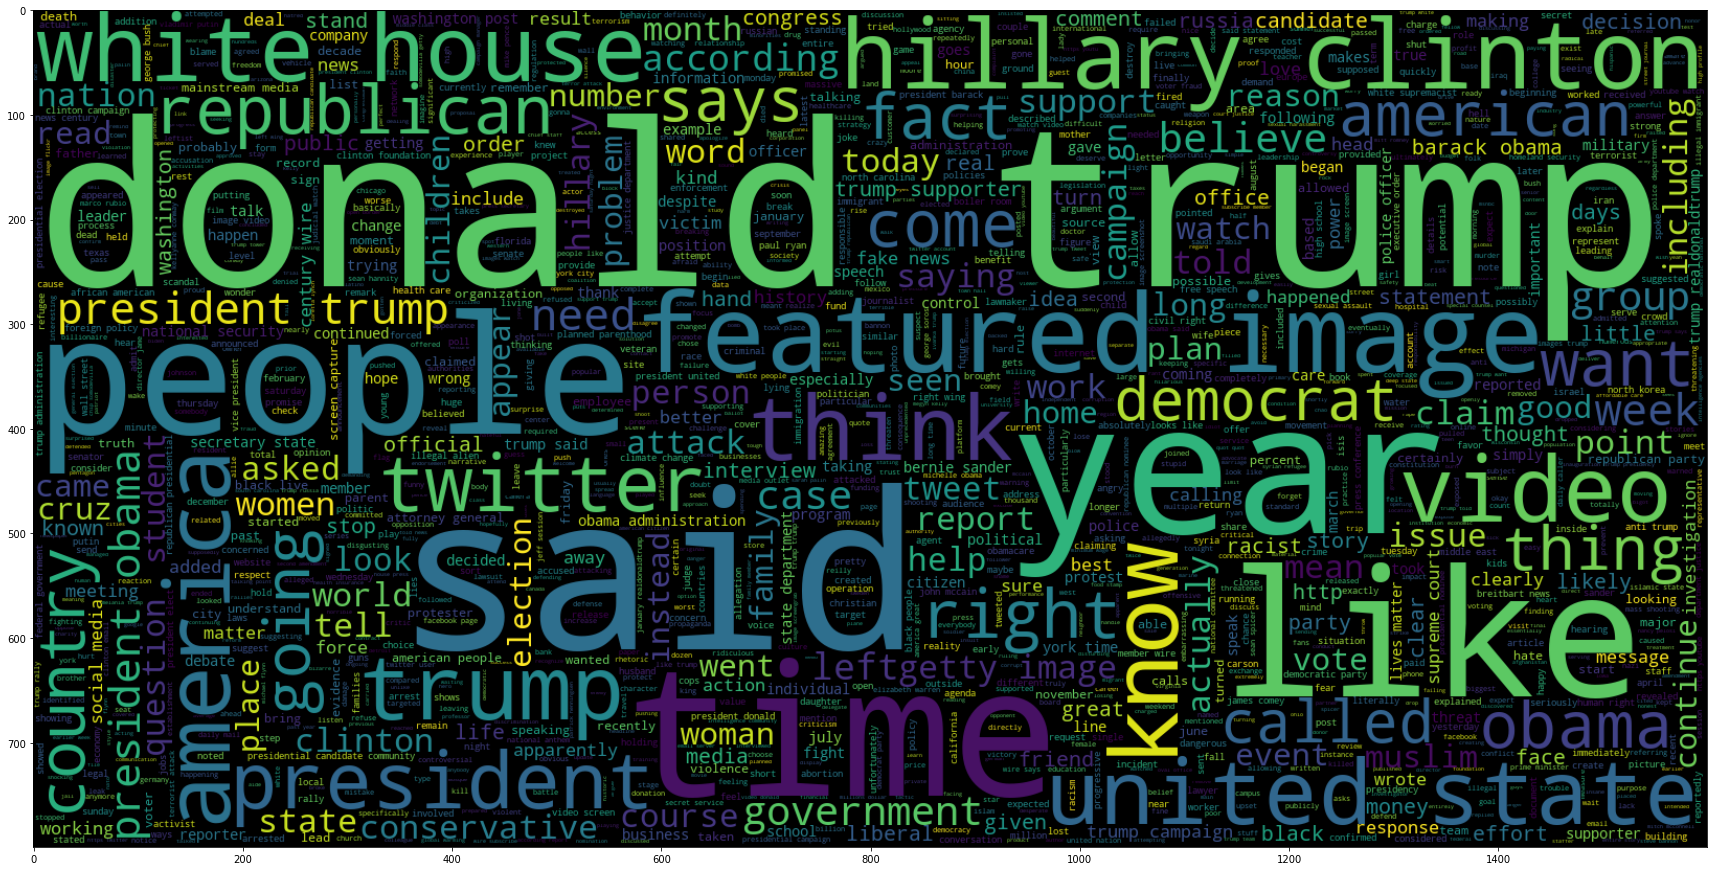

In [ ]:
# Word Cloud for fake news
plt.figure(figsize = (30,30)) 
wc = WordCloud(max_words = 2600 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.is_fake == 1].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

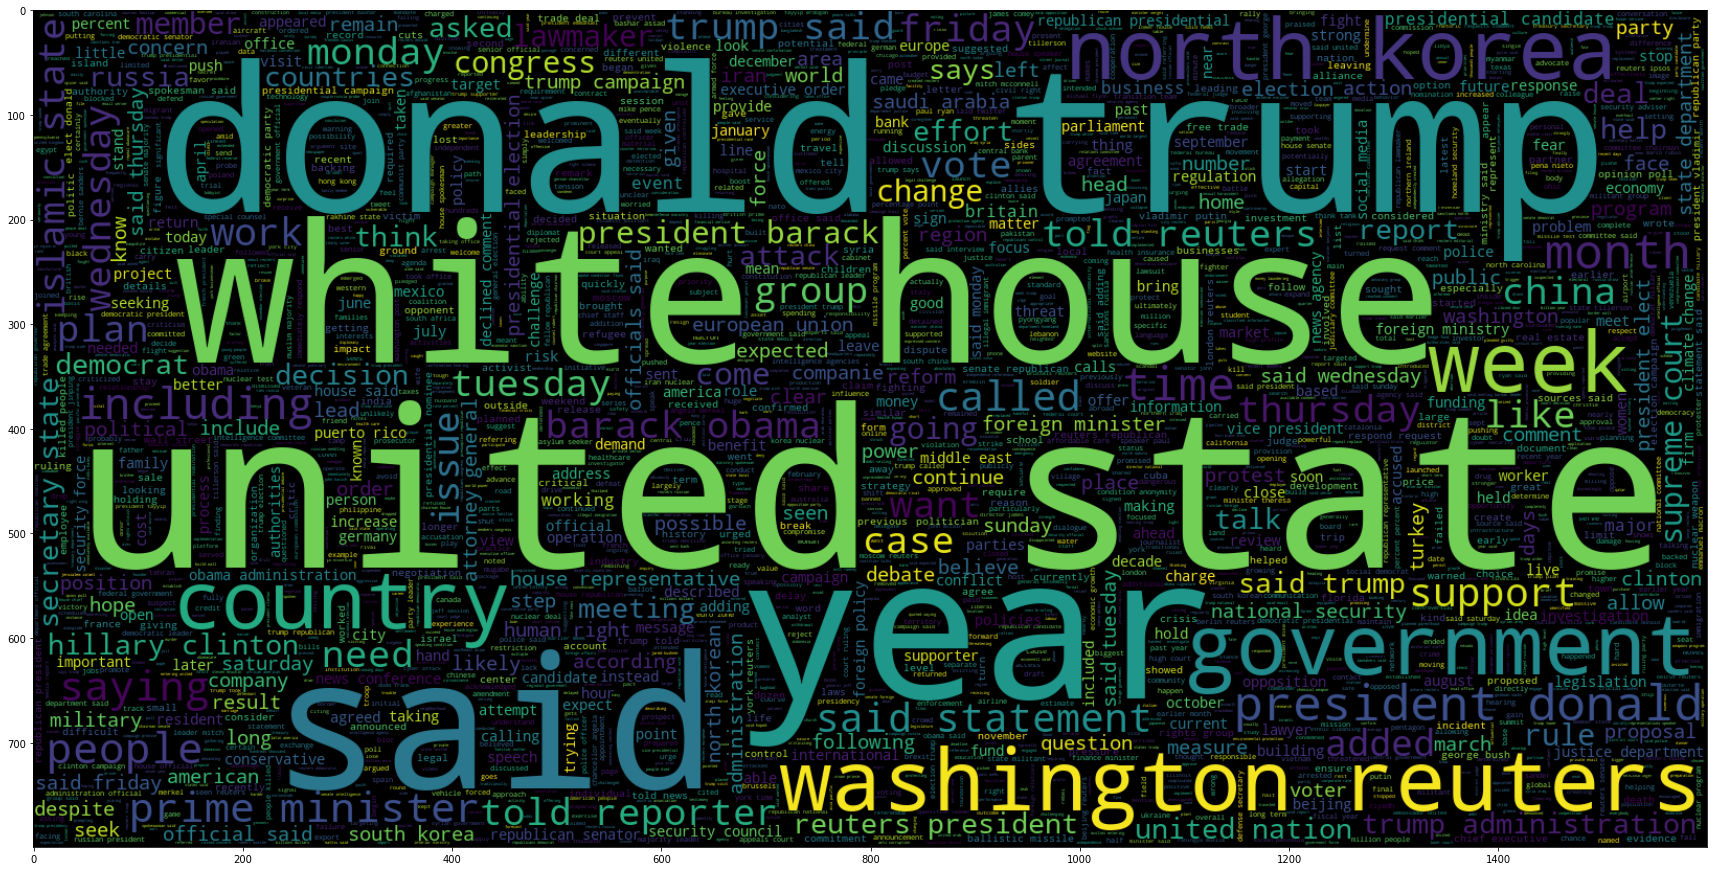

In [ ]:
# For real ones
plt.figure(figsize = (30,30)) 
wc = WordCloud(max_words = 2600 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.is_fake == 0].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

In [ ]:
maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc) # tokenizing every sentence
    if(maxlen<len(tokens)): # and comparing each of them
        maxlen = len(tokens)
print(maxlen) # needed for LSTM

4406


In [ ]:
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined], nbins = 100)
fig.show()

In [ ]:
x_train, x_test, y_train, y_test = tts(df['clean_joined'], df['is_fake'], test_size = 0.20)

In [ ]:
tokenizer = Tokenizer(num_words= len(results)) # unique words are added
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

In [ ]:
len(train_sequences) # 35918
len(test_sequences) # 8980

# OK so not every sentence is the same length, so we will add padding 
# which means we will add 0's.

# max len is up to you, I will stick to maxlen = 4405, you can also try 4405 // 10
padded_train = pad_sequences(train_sequences,maxlen = maxlen, padding = 'post', truncating = 'post')

for i,doc in enumerate(padded_train[11:13]):
     print("The padded encoding for document",i+1," is : ",doc)

The padded encoding for document 1  is :  [ 233 1719 2118 ...    0    0    0]
The padded encoding for document 2  is :  [ 107    1 5290 ...    0    0    0]


In [ ]:
model = Sequential([
                    Embedding(100000, output_dim = 128),
                    tf.keras.layers.Bidirectional(LSTM(128, dropout=0.2)),
                    Dense(128, activation=tf.keras.layers.LeakyReLU(0.2)),
                    Dense(1, activation=tf.nn.sigmoid)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         12800000  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 13,096,193
Trainable params: 13,096,193
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer = Adam(learning_rate=0.0006), loss='binary_crossentropy', metrics=['acc'])

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.2),
                                                 patience = 1, verbose = 1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose = 1)

callbacks = [reduce_lr, early_stop]

In [ ]:
model.fit(padded_train, y_train, epochs = 8, callbacks=callbacks,
          validation_split = 0.25, batch_size = 64, verbose = 1)

Epoch 1/8
421/421 [==============================] - 281s 655ms/step - loss: 0.2216 - acc: 0.8951 - val_loss: 0.0062 - val_acc: 0.9983
Epoch 2/8
421/421 [==============================] - 275s 653ms/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0064 - val_acc: 0.9983

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0002683281700448783.
Epoch 3/8
421/421 [==============================] - 275s 653ms/step - loss: 4.5449e-04 - acc: 0.9999 - val_loss: 0.0060 - val_acc: 0.9983
Epoch 4/8
421/421 [==============================] - 274s 652ms/step - loss: 6.7690e-05 - acc: 1.0000 - val_loss: 0.0060 - val_acc: 0.9983

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00012000000935049685.
Epoch 5/8
421/421 [==============================] - 274s 652ms/step - loss: 3.3198e-05 - acc: 1.0000 - val_loss: 0.0061 - val_acc: 0.9983

Epoch 00005: ReduceLROnPlateau reducing learning rate to 5.36656366121014e-05.
Epoch 00005: early stopping


In [ ]:
padded_test = pad_sequences(test_sequences,maxlen = maxlen, truncating = 'post', padding='post')

In [ ]:
model.evaluate(padded_test, y_test)

281/281 [==============================] - 43s 154ms/step - loss: 0.0071 - acc: 0.9986


[0.0071282824501395226, 0.9985523223876953]

In [ ]:
preds_sigmoid = model.predict(padded_test)
predicted_classes = [1 * (x[0]>=0.5) for x in preds_sigmoid]

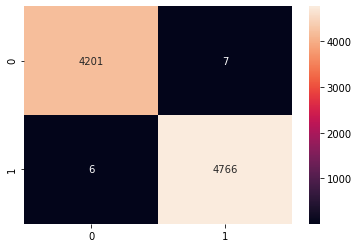

In [ ]:
cm = confusion_matrix(y_test, predicted_classes)  
sns.heatmap(cm, annot=True, fmt = 'd')